In [ ]:
import os
import sys

FS_MOL_CHECKOUT_PATH = os.path.abspath("../")

os.chdir(FS_MOL_CHECKOUT_PATH)
sys.path.insert(0, FS_MOL_CHECKOUT_PATH)

In [ ]:
# from rdkit import Chem
# from rdkit.Chem import Draw
# from rdkit.Chem.Draw import rdMolDraw2D
# from IPython.display import SVG

# # Create the molecule object for benzene
# m = Chem.MolFromSmiles('c1ccccc1')

# # Create a dictionary to store the highlight colors (specified in RGB format)
# highlight_colors = {0: (1, 0, 0), 1: (0, 1, 0)}  # Atom 0: red, Atom 1: green

# # Create a drawer object
# drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)

# # Optional: Specify the size of the atom labels
# opts = drawer.drawOptions()
# opts.atomLabelsFontSize = 20

# # Draw the molecule with the specified highlights
# drawer.DrawMolecule(m, highlightAtoms=highlight_colors.keys(), highlightAtomColors=highlight_colors)

# # Finish the drawing and display it
# drawer.FinishDrawing()
# svg = SVG(drawer.GetDrawingText())
# svg

In [ ]:
import networkx as nx


def tarjan(graph):
    disc = {}  # stores discovery times of visited vertices
    low = {}  # stores the lowest order of vertex reachable from subtree rooted with v
    parent = {}  # stores parent vertices in DFS tree
    articulation_points = set()  # stores articulation points

    time = 0  # time of discovery counter

    def dfs(node):
        nonlocal time
        children = 0  # count of children in DFS Tree

        # Initialize discovery time and low value
        disc[node] = time
        low[node] = time
        time += 1

        for neighbor in graph.neighbors(node):
            # If v is not visited yet, then make it a child of u in DFS tree and recur for it
            if neighbor not in disc:
                parent[neighbor] = node
                children += 1
                dfs(neighbor)

                # Check if the subtree rooted with v has a connection to one of the ancestors of u
                low[node] = min(low[node], low[neighbor])

                # If u is root of DFS tree and has two or more children.
                if parent.get(node) is None and children > 1:
                    articulation_points.add(node)

                # If u is not root and low value of one of its child is more than discovery value of u
                elif parent.get(node) is not None and low[neighbor] >= disc[node]:
                    articulation_points.add(node)

            # Update low value of u for parent function calls
            elif neighbor != parent.get(node):
                low[node] = min(low[node], disc[neighbor])

    for node in graph.nodes:
        if node not in disc:
            dfs(node)

    return list(articulation_points)

In [ ]:
def extract_one_element_sets(set_list):
    result = []
    for s in set_list:
        if len(s) == 1:
            result.extend(list(s))
    return result


# Example usage
sets = [{1, 2}, {3}, {4, 5}, {6}, {7}]
members = extract_one_element_sets(sets)
print(members)

[3, 6, 7]


In [ ]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors as rdescriptors
import networkx as nx

# Define electronegativity values for each element
# This is a simple example, you may want to extend it to cover all elements present in your molecules
ELECTRONEGATIVITY = {
    "H": 2.2,
    "C": 2.55,
    "N": 3.04,
    "O": 3.44,
    "F": 3.98,
    "P": 2.19,
    "S": 2.58,
    "Cl": 3.16,
}


def mol_to_nx(mol):
    G = nx.DiGraph()

    for atom in mol.GetAtoms():
        G.add_node(
            atom.GetIdx(),
            symbol=atom.GetSymbol(),
            electronegativity=ELECTRONEGATIVITY[atom.GetSymbol()],
        )

    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        start_en = G.nodes[start]["electronegativity"]
        end_en = G.nodes[end]["electronegativity"]

        # If atoms have the same electronegativity, add bidirectional edge
        if start_en == end_en:
            G.add_edge(start, end)
            G.add_edge(end, start)
        else:
            # The edge goes from the atom with lower electronegativity to the one with higher
            if start_en < end_en:
                G.add_edge(start, end)
            else:
                G.add_edge(end, start)

    return G


# Test with a molecule
mol = Chem.MolFromSmiles("CCO")
G = mol_to_nx(mol)

# Print edges
print(G.edges)

[(0, 1), (1, 0), (1, 2)]


In [ ]:
from collections import Counter


def find_common_elements(set_list):
    # Count the occurrence of each element in the sets
    element_count = Counter(element for subset in set_list for element in subset)

    # Filter elements that appear in multiple sets
    common_elements = [element for element, count in element_count.items() if count > 1]

    return common_elements

In [ ]:
def remove_common_elements(sets):
    result = []

    for s in sets:
        new_set = s.copy()
        for r in result:
            new_set -= r
        result.append(new_set)

    return result

[{12, 13, 14, 15, 16, 17}, {32, 33, 34, 35, 36, 37, 29, 30, 31}, {20, 21, 22, 23, 24}]
3
20


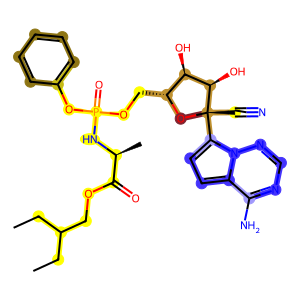

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
import networkx as nx
import random
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

from utils import generate_random_color_list


def highlight_scc(mol):
    # Create a directed graph from the molecule
    graph = nx.DiGraph()
    for bond in mol.GetBonds():
        graph.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
        # graph.add_edge(bond.GetEndAtomIdx(), bond.GetBeginAtomIdx())

    graph2 = nx.DiGraph()
    for bond in mol.GetBonds():
        graph2.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
        graph2.add_edge(bond.GetEndAtomIdx(), bond.GetBeginAtomIdx())

    # Apply Tarjan's algorithm to find SCCs
    sccs = [comp for comp in list(nx.strongly_connected_components(graph)) if len(comp) > 1]
    # sccs = list(nx.strongly_connected_components(graph))

    print(sccs)

    # Generate unique colors for SCCs
    num_sccs = len(sccs)
    print(num_sccs)
    colors = generate_random_color_list(num_sccs)

    # Create an RDKit highlight map
    highlight_map = {}
    for scc_index, scc in enumerate(sccs):
        for atom_index in scc:
            highlight_map[atom_index] = colors[scc_index]

    cut_vertices = tarjan(graph2)

    print(len(cut_vertices))

    for atom_index in cut_vertices:
        if highlight_map.get(atom_index) != None:
            r, g, b = highlight_map[atom_index]
            highlight_map[atom_index] = ((r + 1) / 2, (g + 1) / 2, b)
        else:
            highlight_map[atom_index] = (1, 1, 0)

    # Highlight the molecule based on the SCCs
    drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)
    drawer.DrawMolecule(mol, highlightAtoms=highlight_map.keys(), highlightAtomColors=highlight_map)
    drawer.FinishDrawing()
    svg = SVG(drawer.GetDrawingText())

    return svg


# Example usage
mol = Chem.MolFromSmiles(
    "CCC(COC(=O)[C@@H](NP(=O)(Oc1ccccc1)OC[C@H]1O[C@@]([C@@H]([C@@H]1O)O)(C#N)c1ccc2n1ncnc2N)C)CC"
)
highlighted_svg = highlight_scc(mol)
highlighted_svg

[(0, 1), (1, 2), (2, 3), (2, 40), (3, 4), (4, 5), (5, 6), (5, 7), (7, 8), (7, 39), (8, 9), (9, 10), (9, 11), (9, 18), (11, 12), (18, 19), (19, 20), (22, 27), (22, 29), (23, 26), (24, 25), (27, 28), (37, 38), (40, 41)]


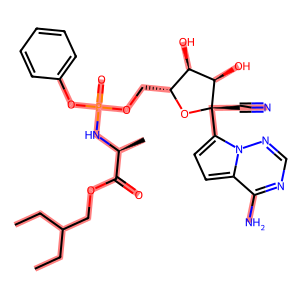

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
import networkx as nx
import random
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG


def generate_random_color():
    r = random.randint(0, 255) / 255
    g = random.randint(0, 255) / 255
    b = random.randint(0, 255) / 255
    return r, g, b


def generate_random_color_list(num_colors):
    color_list = []
    for _ in range(num_colors):
        color = generate_random_color()
        color_list.append(color)
    return color_list


def highlight_scc(mol):
    # Create a directed graph from the molecule
    graph = nx.Graph()
    for bond in mol.GetBonds():
        graph.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
        # graph.add_edge(bond.GetEndAtomIdx(), bond.GetBeginAtomIdx())
    bridges = list(nx.bridges(graph))
    print(bridges)
    # graph2 = nx.DiGraph()
    # for bond in mol.GetBonds():
    #     graph2.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
    #     graph2.add_edge(bond.GetEndAtomIdx(), bond.GetBeginAtomIdx())

    # # Apply Tarjan's algorithm to find SCCs
    # sccs = [comp for comp in list(nx.strongly_connected_components(graph)) if len(comp) > 1]
    # # sccs = list(nx.strongly_connected_components(graph))

    # print(sccs)

    # # Generate unique colors for SCCs
    # num_sccs = len(sccs)
    # print(num_sccs)
    # colors = generate_random_color_list(num_sccs)

    # Create an RDKit highlight map
    highlight_map = {}
    # for scc_index, scc in enumerate(sccs):
    #     for atom_index in scc:
    #         highlight_map[atom_index] = colors[scc_index]

    # cut_vertices = tarjan(graph2)

    # print(len(cut_vertices))
    highlights = []

    for bond in bridges:
        a, b = bond
        bond = mol.GetBondBetweenAtoms(a, b)

        if bond != None:
            highlights.append(bond.GetIdx())

    # Highlight the molecule based on the SCCs
    drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)
    drawer.DrawMolecule(mol, highlightAtoms=[], highlightBonds=highlights)
    drawer.FinishDrawing()
    svg = SVG(drawer.GetDrawingText())

    return svg


# Example usage
mol = Chem.MolFromSmiles(
    "CCC(COC(=O)[C@@H](NP(=O)(Oc1ccccc1)OC[C@H]1O[C@@]([C@@H]([C@@H]1O)O)(C#N)c1ccc2n1ncnc2N)C)CC"
)
highlighted_svg = highlight_scc(mol)
highlighted_svg

In [ ]:
import networkx as nx
from operator import itemgetter


def decompose_graph(G, depth):
    # list to store the resulting components
    components = []

    # recursively decompose the graph
    decompose(G, components, depth)

    # return the list of components
    return components


def decompose(G, components, depth):
    # check the recursion depth
    if depth == 0 or nx.is_biconnected(G):
        components.append(G)
        return

    # find all bridges in the graph
    bridges = list(nx.bridges(G))

    if len(bridges) == 0:
        components.append(G)
        return

    # for each bridge, compute the sizes of the resulting components if the bridge was removed
    sizes = []
    for u, v in bridges:
        G.remove_edge(u, v)
        sizes.append(sorted(len(c) for c in nx.connected_components(G)))
        G.add_edge(u, v)

    # find a bridge that splits the graph into the largest possible components
    _, bridge = max((min(size), bridge) for bridge, size in zip(bridges, sizes))

    # remove the chosen bridge from the graph
    G.remove_edge(*bridge)

    # recursively decompose each component
    for component in nx.connected_components(G):
        decompose(G.subgraph(component).copy(), components, depth - 1)


G = nx.Graph([(1, 2), (1, 3), (2, 3), (2, 4), (4, 5), (5, 6), (5, 7), (6, 7)])
components = decompose_graph(G, 2)

for i, component in enumerate(components):
    print(f"Component {i+1}: {list(component.nodes)}")

Component 1: [1, 2, 3]
Component 2: [4]
Component 3: [5, 6, 7]


0
8


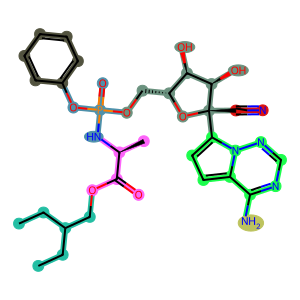

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
import networkx as nx
import random
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG


def generate_random_color():
    r = random.randint(0, 255) / 255
    g = random.randint(0, 255) / 255
    b = random.randint(0, 255) / 255
    return r, g, b


def generate_random_color_list(num_colors):
    color_list = []
    for _ in range(num_colors):
        color = generate_random_color()
        color_list.append(color)
    return color_list


def highlight_scc(mol):
    # Create a directed graph from the molecule
    graph = nx.Graph()
    for bond in mol.GetBonds():
        graph.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())

    # Apply Tarjan's algorithm to find SCCs
    sccs = decompose_graph(graph, 3)
    # sccs = list(nx.strongly_connected_components(graph))
    q = find_common_elements(sccs)
    print(len(q))

    # Generate unique colors for SCCs
    num_sccs = len(sccs)
    print(num_sccs)
    colors = generate_random_color_list(num_sccs)

    # Create an RDKit highlight map
    highlight_map = {}
    for scc_index, scc in enumerate(sccs):
        for atom_index in scc:
            highlight_map[atom_index] = colors[scc_index]

    # Highlight the molecule based on the SCCs
    drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)
    drawer.DrawMolecule(mol, highlightAtoms=highlight_map.keys(), highlightAtomColors=highlight_map)
    drawer.FinishDrawing()
    svg = SVG(drawer.GetDrawingText())

    return svg


# Example usage
mol = Chem.MolFromSmiles(
    "CCC(COC(=O)[C@@H](NP(=O)(Oc1ccccc1)OC[C@H]1O[C@@]([C@@H]([C@@H]1O)O)(C#N)c1ccc2n1ncnc2N)C)CC"
)
highlighted_svg = highlight_scc(mol)
highlighted_svg

33
33
[[0, 16, 17, 15], [1, 2, 3, 18, 19, 20, 21, 22, 23], [4, 5, 6, 7, 8, 9, 24, 25, 26, 27], [32, 10, 12, 13, 14, 28], [11, 29, 30, 31]]
5


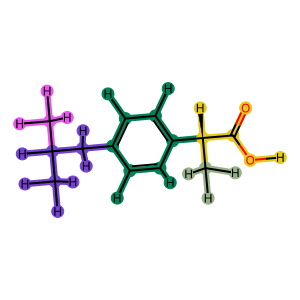

In [6]:
import math
from rdkit import Chem
from rdkit.Chem import Draw
import networkx as nx
import random
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
import networkx as nx
import operator

import networkx as nx
import operator


def girvan_newman(G):
    """
    Applies the Girvan-Newman algorithm on the graph G
    and returns a generator of lists of nodes for each connected component
    after each step.
    """
    # The copy of G here is to avoid any side-effect on the original graph
    G = G.copy()
    while G.number_of_edges() > 0:
        # Compute edge betweenness centrality
        centrality = nx.edge_betweenness_centrality(G)
        # Identify the edge with maximum centrality
        max_centrality_edge = max(centrality.items(), key=operator.itemgetter(1))[0]
        # Remove the edge with highest centrality
        G.remove_edge(*max_centrality_edge)
        # Get the connected components and convert to list of nodes
        components = [list(c) for c in nx.connected_components(G)]
        yield components


def generate_random_color():
    r = random.randint(0, 255) / 255
    g = random.randint(0, 255) / 255
    b = random.randint(0, 255) / 255
    return r, g, b


def generate_random_color_list(num_colors):
    color_list = []
    for _ in range(num_colors):
        color = generate_random_color()
        color_list.append(color)
    return color_list


def highlight_scc(mol):
    # Create a directed graph from the molecule
    graph = nx.Graph()
    # print(len(list(graph.nodes)) * 0.2)
    for bond in mol.GetBonds():
        graph.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())

    graph_size = len(graph.nodes)
    print(graph_size)
    # Apply Tarjan's algorithm to find SCCs
    sccs = list(girvan_newman(graph))
    print(len(sccs))
    random_num = random.choice(list(range(len(graph.nodes))))
    random_num = math.floor(0.1 * graph_size)
    sccs = sccs[random_num]
    print(sccs)
    # sccs = list(nx.strongly_connected_components(graph))
    # q = find_common_elements(sccs)
    # print(len(q))

    # Generate unique colors for SCCs
    num_sccs = len(sccs)
    print(num_sccs)
    colors = generate_random_color_list(num_sccs)

    # Create an RDKit highlight map
    highlight_map = {}
    for scc_index, scc in enumerate(sccs):
        for atom_index in scc:
            highlight_map[atom_index] = colors[scc_index]

    # Highlight the molecule based on the SCCs
    drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)
    drawer.DrawMolecule(mol, highlightAtoms=highlight_map.keys(), highlightAtomColors=highlight_map)
    drawer.FinishDrawing()
    svg = SVG(drawer.GetDrawingText())

    return svg


# Example usage
mol = Chem.MolFromSmiles("CC(C)Cc1ccc(cc1)[C@@H](C)C(=O)O")
mol = Chem.AddHs(mol)
highlighted_svg = highlight_scc(mol)
highlighted_svg

In [13]:
from fs_mol.data.torch_dl import FSMOLHTorchDataset
from fs_mol.utils.visualization import visualize_pyg_mol_with_poses, display_molecules

In [14]:
train_dataset = FSMOLHTorchDataset("train", "pyg")

pyg_mols = [sample for task in train_dataset for sample in task.samples]

Done!


In [15]:
import math
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx
from itertools import islice


def select_subgraph_by_indices(graph, node_indices):
    subgraph = nx.Graph()

    for index in node_indices:
        node = list(graph.nodes)[index]
        subgraph.add_node(node)

    for u, v in graph.edges:
        if u in node_indices and v in node_indices:
            subgraph.add_edge(u, v)

    return subgraph


def get_a_division(data):
    G = to_networkx(data, to_undirected=True)
    node_count = data.x.shape[0]
    random_max = math.floor(node_count * 0.3)
    random_num = random.choice(list(range(random_max)))
    sccs = list(islice(girvan_newman(G), random_num + 1))
    sccs = sccs[random_num]

    subgraphs = []

    for subgraph_indices in sccs:
        selected_subgraph = select_subgraph_by_indices(G, subgraph_indices)
        subgraph_data = nx_to_pyg(selected_subgraph, data)
        subgraphs.append(subgraph_data)

    return subgraphs


def nx_to_pyg(G, data):
    # Create a mapping of old node indices to new node indices
    node_mapping = {old: new for new, old in enumerate(G.nodes)}

    # Reconstruct edge_index with new node indices
    edge_index = (
        torch.tensor([(node_mapping[i], node_mapping[j]) for i, j in G.edges()]).t().contiguous()
    )

    # Reconstruct node features with new node indices
    x = data.x[list(node_mapping.keys())]

    # Reconstruct node positions with new node indices
    pos = data.pos[list(node_mapping.keys())]

    return Data(x=x, edge_index=edge_index, pos=pos)

[Data(x=[13], edge_index=[2, 12], pos=[13, 3]), Data(x=[11], edge_index=[2, 11], pos=[11, 3]), Data(x=[7], edge_index=[2, 6], pos=[7, 3])]
62
12
11
6


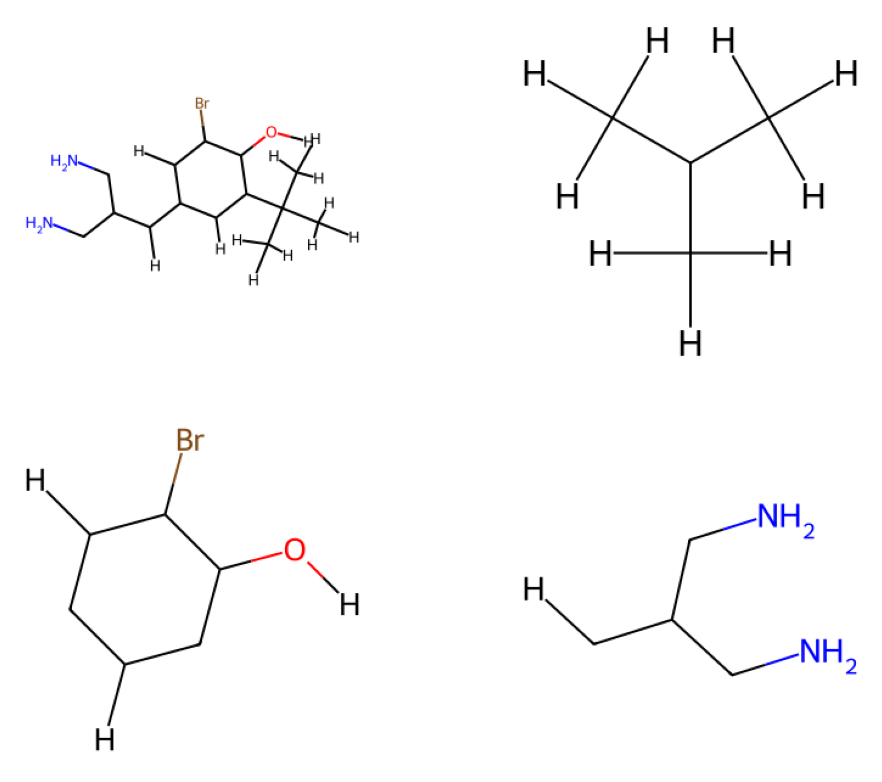

In [16]:
graph = pyg_mols[0]

division = get_a_division(graph)

print(division)

display_molecules([visualize_pyg_mol_with_poses(g) for g in [graph] + division], rows=2)

In [17]:
from torch.utils.data import Dataset
from torch_geometric.data import Batch
import torch


class MolCombinerDataset(Dataset):
    def __init__(self, datafold) -> None:
        super().__init__()

        self.mols = torch.load(f"/FS-MOL/datasets/all_{datafold}_mxm_mols.pt")

    def __getitem__(self, index):
        src_mol = self.mols[index]

        return get_a_division(src_mol), src_mol

    def __len__(self):
        return len(self.mols)


dataset = MolCombinerDataset("train")

dataset[0]

KeyboardInterrupt: 

In [ ]:
from torch.utils.data import DataLoader
from torch import nn
import numpy as np

In [ ]:
import torch.nn.functional as F


def collate_fn(batch):
    # Unpack the batch
    division_lists, src_mols = zip(*batch)

    # Concatenate all divisions and src_mols in the batch
    all_divisions = [division for sublist in division_lists for division in sublist]
    all_src_mols = list(src_mols)

    # Create Batch objects
    division_batch = Batch.from_data_list(all_divisions)
    src_mol_batch = Batch.from_data_list(all_src_mols)

    # Create a tensor that indicates the molecule to which each division belongs
    molecule_index = [i for i, sublist in enumerate(division_lists) for _ in sublist]
    division_batch.molecule_index = torch.tensor(molecule_index)

    return division_batch, src_mol_batch


data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [ ]:
from MXMNet.model import MXMNet, Config

attention_mechanism = ScaledDotProductAttention(640, 640)
model = MXMNet(Config(128, 5, 5.0, 128, 512))


for division_batch, src_mol_batch in data_loader:
    print(division_batch)
    frag_repr = model(division_batch)
    output_repr = model(src_mol_batch)
    output_attn = attention_mechanism(frag_repr, division_batch.molecule_index)
    print(output_attn.shape)
    break

DataBatch(x=[1531], edge_index=[2, 1371], pos=[1531, 3], batch=[1531], ptr=[231], molecule_index=[230])
torch.Size([32, 640])
